## JPEG

### Intro

L'objectif de ce projet était de réimplémenter entièrement l'algorithme JPEG. Qu'est-ce que JPEG ? JPEG, pour Joint Photographic Experts Group, est un algorithme de compression d'image avec perte. C'est-à-dire qu'après compression de l'image, une fois décompressée, on aura une perte de qualité car l'information qui nous permettait d'avoir une image en très haute définition a été jetée. Pourquoi jeter de l'information ? Dans le cas de la compression d'image, il n'est pas toujours utile de garder absolument toute l'information A l'oeil nu, si on ne zoom pas trop sur la photo, on n'est pas toujours en mesure de différencier ces deux images. En jetant une partie, le poids de l'image en (en octet) peut fortement diminuer, et donc transférer cette dernière plus rapidement par mail, par messagerie électronique ou en stocker davantage sur son disque dur.
 
 
A partir de maintenant, nous allons vous expliquer au fur et à mesure les algorithmes de compression et de décompression JPEG.
 
 Il faut savoir qu'une image, ce n'est rien d'autre qu'un tableau de pixels en 2 dimensions. Une cellule de ce tableau est de l'information sur un pixel.
 
 Nous différencions deux types d'images. Les images en niveau de gris et les images couleurs. Pourquoi ? Car la façon dont nous allons stocker leurs informations va différer. Pour les images en niveau de gris, chaque cellule du tableau pourra contenir uniquement l'intensité du niveau de gris du pixel, qu'on peut stocker sur 1 octet car on a que 256 niveaux de gris possible. En revanche... (à continuer)

In [69]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from skimage.transform import resize
from scipy.fftpack import dct, idct

L'image sur laquelle l'algorithme est teste est la suivante (en couleur et en niveaux de gris).
Le format choisi est '.tiff' afin de conserver un maximum d'information.

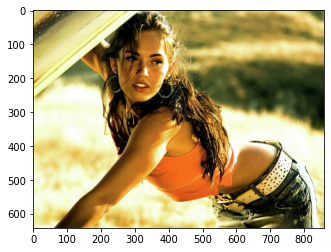

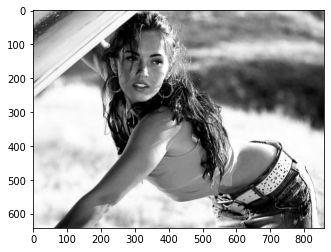

In [6]:
img_rgb = Image.open("./test.tiff")
img_gray = img_rgb.convert('L')
img_arr_rgb = np.array(img_rgb)
img_arr_gray = np.array(img_gray)

plt.rcParams["figure.figsize"] = [8,4]
plt.imshow(img_arr_rgb)
plt.show()
plt.imshow(img_arr_gray, cmap='gray')
plt.show()

# From RGB to YUV

En RGB, l'image (en couleur) est representee a l'aide d'une matrice en 3 dimensions (m, n, 3): m lignes, n colonnes et 3 canaux (1 rouge, 1 vert et 1 bleu).

YUV est un moyen de representer les informations contenues dans les images couleurs d'une facon differente. Y correspond a l'image en niveaux de gris (luminance)

In [7]:
# from RGB to YUV

def to_yuv(img):
    '''
    RGB image into YUV
    '''
    r = img[:, :, 0]
    g = img[:, :, 1]
    b = img[:, :, 2]

    y = 0.299 * r  + 0.587 * g + 0.114 * b
    u = -0.14713 * r  +  -0.28886 * g + 0.436 * b
    v = 0.615 * r  +  -0.51499 * g + -0.10001 * b

    return y, u, v

def to_rgb(img):
    '''
    From YUV to RGB
    '''
    y = img[:, :, 0]
    u = img[:, :, 1]
    v = img[:, :, 2]

    r = (y + 1.13983 * v).astype('uint8')
    g = (y + -0.39465 * u + -0.58060 * v).astype('uint8')
    b = (y + 2.03211 * u).astype('uint8')

    return r, g, b


Comme on peut le voir, on converti l'image en YUV puis en la reconverti en RGB. On retrouve bien l'image de depart

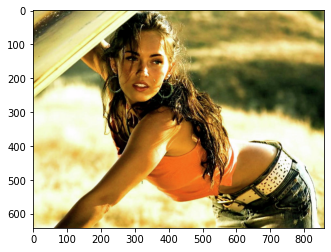

In [11]:
# TEST de la conversion

y, u, v = to_yuv(img_arr_rgb)
img_yuv = np.dstack((y, u, v))
r, g, b = to_rgb(img_yuv)
img_rgb = np.dstack((r, g, b))
plt.imshow(img_rgb)
plt.show()

### Transform the image into 8x8 blocks

Expliquer la premier etape

In [19]:
def get_next_8(nbr):
    '''
    Get next multiple of 8
    '''
    if nbr % 8 == 0:
        return nbr
    r = nbr // 8
    return (r + 1) * 8

def zeros_padding(img):
    '''
    Padd the image with 0
    '''
    shape = img.shape

    # nbr of columns/rows to add
    diff_rows = get_next_8(shape[0]) - shape[0]
    diff_cols = get_next_8(shape[1]) - shape[1]

    if diff_cols != 0:
        zeros_cols = np.zeros((shape[0], diff_cols))
        img = np.concatenate((img, zeros_cols), axis=1)

    if diff_rows != 0:
        zeros_rows = np.zeros((diff_rows, shape[1] + diff_cols))
        img = np.concatenate((img, zeros_rows), axis=0)

    return img

def symmetrical_padding(img):
    '''
    Padd the image with symmetrical rows and columns
    -> avoid creating high frequencies
    '''
    shape = img.shape

    # nbr of column/rows to add
    diff_rows = get_next_8(shape[0]) - shape[0]
    diff_cols = get_next_8(shape[1]) - shape[1]


    if diff_cols != 0:
        sym_arr = np.flip(img[:, -diff_cols:], axis=1)
        img = np.concatenate((img, sym_arr), axis=1)

    if diff_rows != 0:
        sym_arr = np.flip(img[-diff_rows:, :], axis=0)
        img = np.concatenate((img, sym_arr), axis=0)

    return img

def img_to_blocks(img, padding='zeros'):
    '''
    Get all the blocks (8x8)
    padding: 'zeros'/'symmetrical'
    '''
    if padding == 'zeros':
        img = zeros_padding(img)
    elif padding == 'symmetrical':
        img = symmetrical_padding(img)
    else:
        print("ERROR unknown padding")

    shape = img.shape

    n_rows = shape[0] // 8
    n_cols = shape[1] // 8
    res = np.empty((n_rows, n_cols, 8, 8))

    for i in range(n_rows):
        for j in range(n_cols):
            row_min, row_max = i * 8, (i + 1) * 8
            col_min, col_max = j * 8, (j + 1) * 8
            res[i, j, :, :] = img[row_min:row_max, col_min:col_max]

    return res

def blocks_to_img(blocks):
    '''
    Convert matrix from blocks representation into image representation
    '''
    shape = blocks.shape
    res = np.empty((shape[0] * 8, shape[1] * 8))
    for i in range(shape[0]):
        for j in range(shape[1]):
            row_min, row_max = i * 8, (i + 1) * 8
            col_min, col_max = j * 8, (j + 1) * 8
            res[row_min:row_max, col_min:col_max] = blocks[i, j]
        
    return res

Ici on teste de le decoupage par block et le padding. On retrouve bien l'image de depart avec du padding.

In [20]:
blocks = img_to_blocks(img_arr_gray, padding='symmetrical')
tmp = blocks_to_img(blocks)

img = symmetrical_padding(img_arr_gray)
assert True == np.all(tmp==img)

### DCT

Expliquer pourquoi DCT. TODO

Utilisation du module scipy pour le calcule de la DCT/IDCT.
Les formules de la DCT sont expliquees sur ce papier: http://m.reznik.org/papers/SPIE07_MPEG-C_IDCT.pdf

In [21]:
## COMPRESSION

def block_dct(block):
    return np.round(dct(dct((block-128).T, norm='ortho').T, norm='ortho'))

def img_dct(img_blocks):
    shape = img_blocks.shape
    for i in range(shape[0]):
        for j in range(shape[1]):
            img_blocks[i, j, :, :] = block_dct(img_blocks[i, j])
    return img_blocks
    
def block_idct(block):
    return np.round(idct(idct(block.T, norm='ortho').T, norm='ortho')) + 128

def img_idct(img_blocks):
    shape = img_blocks.shape
    for i in range(shape[0]):
        for j in range(shape[1]):
            img_blocks[i, j, :, :] = block_idct(img_blocks[i, j])
    return img_blocks


In [22]:
# TEST dct et idct

mat = np.array([
  [16,  11,  10,  16,  24,  40,  51,  61],
  [12,  12,  14,  19,  26,  58,  60,  55],
  [14,  13,  16,  24,  40,  57,  69,  56],
  [14,  17,  22,  29,  51,  87,  80,  62],
  [18,  22,  37,  56,  68, 109, 103,  77],
  [24,  35,  55,  64,  81, 104, 113,  92],
  [49,  64,  78,  87, 103, 121, 120, 101],
  [72,  92,  95,  98, 112, 100, 103,  99]], dtype=float)

blocks_img = mat.reshape((1, 1, 8, 8))
print(blocks_img)
res = img_dct(blocks_img)
print(res)
print(img_idct(res))

[[[[ 16.  11.  10.  16.  24.  40.  51.  61.]
   [ 12.  12.  14.  19.  26.  58.  60.  55.]
   [ 14.  13.  16.  24.  40.  57.  69.  56.]
   [ 14.  17.  22.  29.  51.  87.  80.  62.]
   [ 18.  22.  37.  56.  68. 109. 103.  77.]
   [ 24.  35.  55.  64.  81. 104. 113.  92.]
   [ 49.  64.  78.  87. 103. 121. 120. 101.]
   [ 72.  92.  95.  98. 112. 100. 103.  99.]]]]
[[[[-563. -168.  -15.   30.  -31.    9.    1.   -3.]
   [-194.   -2.   38.    5.    7.    4.    6.   -6.]
   [  32.   44.   11.  -22.   15.  -11.   -6.    4.]
   [  -3.  -28.   -1.   -0.   -3.    7.    4.   -3.]
   [   2.   11.    1.    1.    4.   -5.    1.   -3.]
   [  -1.   -4.    2.    3.    1.   -3.    0.    3.]
   [ -10.    6.    4.   -9.    8.   -1.   -6.    8.]
   [   8.   -2.   -3.    1.    3.    4.   -2.   -1.]]]]
[[[[ 16.  11.   9.  16.  24.  40.  51.  61.]
   [ 13.  12.  14.  19.  26.  58.  60.  55.]
   [ 14.  12.  16.  24.  40.  57.  69.  56.]
   [ 14.  17.  22.  29.  51.  87.  80.  62.]
   [ 18.  22.  37.  56.  68. 1

### Quantification step

TODO

In [23]:
## COMPRESSION

def quantification(block, luminance=True, q=75):
    '''
    Quantification step on 1 8x8 block
    luminance: Wether it's for luminance or chrominance image
    '''

    if luminance:
        q_luminance = np.array([
            [16, 11, 10, 16, 24, 40, 51, 61],
            [12, 12, 14, 19, 26, 58, 60, 55],
            [14, 13, 16, 24, 40, 57, 69, 56],
            [14, 17, 22, 29, 51, 87, 80, 62],
            [18, 22, 37, 56, 68, 109, 103, 77],
            [24, 35, 55, 64, 81, 104, 113, 92],
            [49, 64, 78, 87, 103, 121, 120, 101],
            [72, 92, 95, 98, 112, 100, 103, 99]
        ])
        
        if q < 50:
            alpha = 5000 / q
        else:
            alpha = 200  - 2 * q
        q_luminance = (alpha * q_luminance + 50) / 100
        return np.round(block / q_luminance), q_luminance

    else:
        q_chrominance = np.array([
            [17, 18, 24, 47, 99, 99, 99, 99],
            [18, 21, 26, 66, 99, 99, 99, 99],
            [24, 26, 56, 99, 99, 99, 99, 99],
            [47, 66, 99, 99, 99, 99, 99, 99],
            [99, 99, 99, 99, 99, 99, 99, 99],
            [99, 99, 99, 99, 99, 99, 99, 99],
            [99, 99, 99, 99, 99, 99, 99, 99],
            [99, 99, 99, 99, 99, 99, 99, 99]
        ])
        
        return np.round(block / q_chrominance), q_chrominance
    
def compute_quantification(img_blocks, luminance=True, q=75):
    '''
    Compute quantification on each block
    luminance: weather its a luminance block or not
    q: compression quality
    '''
    shape = img_blocks.shape
    
    for i in range(shape[0]):
        for j in range(shape[1]):
            img_blocks[i, j, :, :], q_mat = quantification(img_blocks[i, j], luminance, q)
    return img_blocks, q_mat

## DECOMPRESSION

def dequantification(block, quantification_mat):
    '''
    Quantification step on 1 8x8 block
    luminance: Wether it's for luminance or chrominance image
    '''
    return np.einsum('ij,ij->ij', block, quantification_mat)

def compute_dequantification(img_blocks, quantification_mat):
    '''
    Dequantification step on each block
    '''
    shape = img_blocks.shape
    
    for i in range(shape[0]):
        for j in range(shape[1]):
            img_blocks[i, j, :, :] = dequantification(img_blocks[i, j], quantification_mat)
    return img_blocks

In [26]:
mat = np.array([
  [16,  11,  10,  16,  24,  40,  51,  61],
  [12,  12,  14,  19,  26,  58,  60,  55],
  [14,  13,  16,  24,  40,  57,  69,  56],
  [14,  17,  22,  29,  51,  87,  80,  62],
  [18,  22,  37,  56,  68, 109, 103,  77],
  [24,  35,  55,  64,  81, 104, 113,  92],
  [49,  64,  78,  87, 103, 121, 120, 101],
  [72,  92,  95,  98, 112, 100, 103,  99]], dtype=float)

# quantification 
mat_blocks = mat.reshape((1, 1, 8, 8))
mat_DCT = img_dct(mat_blocks)
print("MAT after DCT ")
print(mat_DCT)
print()
mat_quant, q_mat = compute_quantification(mat_DCT, luminance=True, q=90)
print("MAT after quantification")
print(mat_quant)
print()
print("Quantificaton matrix")
print(q_mat)
print()

# dequantification
mat_dequant = compute_dequantification(mat_quant, q_mat)
print("MAT after dequantification")
print(mat_dequant)

MAT after DCT 
[[[[-563. -168.  -15.   30.  -31.    9.    1.   -3.]
   [-194.   -2.   38.    5.    7.    4.    6.   -6.]
   [  32.   44.   11.  -22.   15.  -11.   -6.    4.]
   [  -3.  -28.   -1.   -0.   -3.    7.    4.   -3.]
   [   2.   11.    1.    1.    4.   -5.    1.   -3.]
   [  -1.   -4.    2.    3.    1.   -3.    0.    3.]
   [ -10.    6.    4.   -9.    8.   -1.   -6.    8.]
   [   8.   -2.   -3.    1.    3.    4.   -2.   -1.]]]]

MAT after quantification
[[[[-152.  -62.   -6.    8.   -6.    1.    0.   -0.]
   [ -67.   -1.   12.    1.    1.    0.    0.   -1.]
   [  10.   14.    3.   -4.    2.   -1.   -0.    0.]
   [  -1.   -7.   -0.   -0.   -0.    0.    0.   -0.]
   [   0.    2.    0.    0.    0.   -0.    0.   -0.]
   [  -0.   -1.    0.    0.    0.   -0.    0.    0.]
   [  -1.    0.    0.   -1.    0.   -0.   -0.    0.]
   [   1.   -0.   -0.    0.    0.    0.   -0.   -0.]]]]

Quantificaton matrix
[[ 3.7  2.7  2.5  3.7  5.3  8.5 10.7 12.7]
 [ 2.9  2.9  3.3  4.3  5.7 12.1 12.5 11.

In [28]:
def reverse_zigzag(mat):
    '''
    Reverse Zigzag iteration over matrix 'mat' to count nb of zeros
    '''
    shape = mat.shape
    n_rows, n_cols = shape[0], shape[1]
    i, j, idx = n_rows - 1, n_cols - 1, 0

    # first element case
    if (mat[i, j] != 0):
        return idx
    idx += 1

    while (idx < n_rows * n_cols):
        # after diagonals cases
        if (j > 0):
            j -= 1
        else:
            i -= 1

        # diagonal from left to right
        while (j < n_cols and i >= 0):
            if (mat[i, j] != 0):
                return idx
            idx += 1
            i -= 1
            j += 1

        # rectify out of bound
        j -= 1
        i += 1

        # corner case
        if (i > 0):
            i -= 1
        else:
            j -= 1

        # diagonal from right to left
        while (j >= 0 and i < n_rows):
            if (mat[i, j] != 0):
                return idx
            idx += 1
            j -= 1
            i += 1

        # out of bound
        j += 1
        i -= 1
    
    return idx

def zigzag(mat):
    '''
    Zigzag iteration over matrix 'mat'
    '''
    # init
    i, j, idx = 0, 0, 0
    n_rows, n_cols = mat.shape

    nb_elm = reverse_zigzag(mat)
    nb_elm = n_rows * n_cols - nb_elm

    if (nb_elm == 0):
        return np.array([])
    res = np.zeros(nb_elm)

    # first element case
    res[idx] = mat[i][j]
    idx += 1

    while (idx < nb_elm):
        if (j < n_cols -1):
            j += 1
        else:
            i += 1

        # diagonal from right to left
        while (j >= 0 and i < n_rows):
            if (idx >= nb_elm):
                return res
            res[idx] = mat[i][j]
            idx += 1
            i += 1
            j -= 1

        # out of bound i and j
        j += 1
        i -= 1

        if (i < n_rows - 1):
            i += 1
        else:
            j += 1

        # diagonal from left to right
        while (i >= 0 and j < n_cols):
            if (idx >= nb_elm):
                return res
            res[idx] = mat[i][j]
            idx += 1
            i -= 1
            j += 1

        # out of bound i and j
        i += 1
        j -= 1

    return res

def apply_zigzag(mat_blocks):
    '''
    Apply zigzag on each block
    '''
    shape = mat_blocks.shape
    res = []
    
    for i in range(shape[0]):
        for j in range(shape[1]):
            res.append(zigzag(mat_blocks[i, j]))
    return res

def zigzag_to_matrix(arr):
    '''
    From array into zigzag matrix
    '''
    res = np.zeros((8, 8))

    # init
    i, j, idx = 0, 0, 0
    n_rows, n_cols = res.shape

    if len(arr) == 0:
        return res
    # first element case
    res[i][j] = arr[idx]
    idx += 1

    while (idx < len(arr)):
        if (j < n_cols -1):
            j += 1
        else:
            i += 1

        # diagonal from right to left
        while (j >= 0 and i < n_rows):
            if (idx >= len(arr)):
                return res
            res[i][j] = arr[idx]
            idx += 1
            i += 1
            j -= 1

        # out of bound i and j
        j += 1
        i -= 1

        if (i < n_rows - 1):
            i += 1
        else:
            j += 1

        # diagonal from left to right
        while (i >= 0 and j < n_cols):
            if (idx >= len(arr)):
                return res
            res[i][j] = arr[idx]
            idx += 1
            i -= 1
            j += 1

        # out of bound i and j
        i += 1
        j -= 1

    return res

def build_zigzag_blocks(compressed_data, img_shape):
    '''
    Build the (n, m, 8, 8) blocks matrix of the image
    compressed_data: data in compressed format (list of numpy array) for each block
    img_shape: shape (number of block)
    '''
    res = np.empty((img_shape[0], img_shape[1], 8, 8))
    
    for i in range(img_shape[0]):
        for j in range(img_shape[1]):
            block = compressed_data[i * img_shape[1] + j]
            res[i, j, :, :] = zigzag_to_matrix(block)
            
    return res

In [40]:
# TEST zigzag

img_blocks = img_to_blocks(img_arr_gray)
dct_blocks = img_dct(img_blocks)
mat, _ = compute_quantification(dct_blocks)
cp_data = apply_zigzag(img_blocks)
shape = (img_blocks.shape[0], img_blocks.shape[1])
res = build_zigzag_blocks(cp_data, shape)
print(cp_data)
assert True == np.all(res == mat)

[array([63., -6., -5., -4., -8., -5., -2., -4., -7., -4., -2., -4., -4.,
       -2., -1., -0., -1., -2., -2., -1., -1., -0., -1., -1., -1.]), array([67., -2.,  2.,  0., -0., -1.]), array([67.,  0.,  1., -1.,  0.,  0., -1.,  0.,  1.]), array([66.,  4.,  4., -2., -0.,  0., -0., -0., -1.]), array([61.,  3.,  5.,  0.,  0., -0., -0.,  0., -0.,  1.]), array([53.,  5., 10., -1., -3., -1.,  0.,  1.,  1.,  1., -1., -0.,  1.]), array([34.,  3.,  8.,  3.,  9.,  4.,  0., -1., -1.,  2., -0., -1., -4.,
       -0.,  1.,  0.,  0.,  1.,  3.,  0.,  0., -0., -0., -1., -2.]), array([ 1., 16., 19., -1., -1.,  3.,  3., -5., -7.,  3.,  0.,  3.,  1.,
        1.,  3., -0., -1., -2.,  2., -1., -0.,  0., -0., -0.,  2.]), array([ -7.,  18., -16.,   9., -26.,  -0.,   6.,  -6.,   5.,   3.,   1.,
        -7.,   6.,   1.,   0.,  -2.,   6.,  -3.,   1.,  -1.,  -0.,   0.,
         0.,  -2.,   3.,  -2.,   1.,  -0.,  -0.,  -0.,   1.,  -1.,  -0.,
         1.,   0.,   0.,   0.,  -0.,   0.,   0.,  -0.,   0.,   0.,   0.,
    

#### Jpeg Compression / Decompression

In [115]:
def undersampling(img, chrominance):
    '''
    chrominance: '4:2:2' / '4:2:0'
    '''
    # remove columns
    if chrominance == '4:2:2' or chrominance == '4:2:0':
        pos = np.arange(0, img.shape[1], 2)
        img = img[:, pos]
    # remove rows
    if chrominance == '4:2:0':
        pos = np.arange(0, img.shape[0], 2)
        img = img[pos, :]
    return symmetrical_padding(img)

def interpolation(img, output_shape):
    '''
    Interpolate image
    '''
    return resize(img, output_shape)

def get_nbv_cp(cp_data):
    '''
    Get the number of values in compressed data
    '''
    nb = 0
    for arr in cp_data:
        nb += len(arr)
    return nb

def get_nbv_img(img_arr):
    '''
    Get number of values in 2d image
    '''
    shape = img_arr.shape
    return shape[0] * shape[1]

In [112]:
def compress_img_arr(mat, q, luminance=True, chrominance='4:4:4'):
    '''
    Compress a 2 dimension image
    '''
    print("COMPRESSION")
    if luminance == False and (chrominance == '4:2:2' or chrominance == '4:2:0'):
        mat = undersampling(mat, chrominance)
    
    print("1) Transform into blocks")
    # transform the input image into 8x8 blocks
    mat_blocks = img_to_blocks(mat, padding='symmetrical')
    shape = (mat_blocks.shape[0], mat_blocks.shape[1])
    
    print("2) Compute DCT")
    # compute the DCT on each block
    mat_dct = img_dct(mat_blocks)
    
    print("3) Quantification")
    # compute quantification step on each block
    mat_quant, q_mat = compute_quantification(mat_dct, luminance, q)
    
    print("4) Zigzag")
    # apply zigzag on each block
    compressed_mat = apply_zigzag(mat_quant)
    
    return compressed_mat, q_mat, shape

def decompress_img_arr(compressed_data, quantif_mat, blocks_shape, default_shape, chrominance='4:4:4'):
    '''
    compressed_data: list of numpy array with compressed data for each block
    quantif_mat: quantification matricx used
    blocks_shape: number of blocks (rows and columns)
    default_shape: defautl matrix shape (before padding)
    chrominance: type of chrominance
    '''
    print("DECOMPRESSION")
    
    # from compressed data into blocks
    print("1) Reverse Zigzag")
    zigzag_blocks = build_zigzag_blocks(compressed_data, blocks_shape)
    
    # dequantification
    print("2) Dequantification")
    dequant_blocks = compute_dequantification(zigzag_blocks, quantif_mat)
    
    # reverse DCT
    print("3) Reverse DCT")
    idct_blocks = img_idct(dequant_blocks)
    
    # from blocks into image
    print("4) Transform into image")
    image = blocks_to_img(idct_blocks)
    
    # add columns
    if chrominance == '4:2:2':
        image = interpolation(image, (image.shape[0], image.shape[1] * 2))
        
    # add rows and columns
    elif chrominance == '4:2:0':
        image = interpolation(image, (image.shape[0] * 2, image.shape[1] * 2))
    
    rows, cols = default_shape
    return image[:rows, :cols]

def jpeg_compress(img, mode='rgb', chrominance='4:4:4', q=75):
    '''
    img: image to compress
    mode: image representation (rgb/yuv)
    chromonance: 4:4:4 / 4:2:2 / 4:2:0 
    q: quality indice for luminance quantification
    '''
    # gray format
    if (len(img.shape) == 2):
        img_default_shape = img.shape
        cp_data, qmat, blocks_shape = compress_img_arr(img, q, luminance=True, chrominance='4:4:4')
        return (cp_data), (qmat, qmat), blocks_shape, img_default_shape 
    
    # yuv compression format
    if (mode == 'yuv'):
        # convert the image into yuv
        y, u, v = to_yuv(img)
        img_default_shape = y.shape
        
        # compress y / u / v
        cp_data_y, qmat_lum, blocks_shape = compress_img_arr(y, q, luminance=True, chrominance=chrominance)
        cp_data_u, qmat_chro, _ = compress_img_arr(u, q, luminance=False, chrominance=chrominance)
        cp_data_v, _, _ = compress_img_arr(v, q, luminance=False, chrominance=chrominance)
        
        return (cp_data_y, cp_data_u, cp_data_v), (qmat_lum, qmat_chro), blocks_shape, img_default_shape
    # rgb compression format
    else:
        # get r / g / b
        r = img[:, :, 0]
        g = img[:, :, 1]
        b = img[:, :, 2]
        
        img_default_shape = r.shape
        
        # compress r / g / b
        cp_data_r, qmat, blocks_shape = compress_img_arr(r, q)
        cp_data_g, _, _ = compress_img_arr(g, q)
        cp_data_b, _, _ = compress_img_arr(b, q)
        
        return (cp_data_r, cp_data_g, cp_data_b), (qmat, qmat), blocks_shape, img_default_shape
        

def jpeg_decompress(cp_data, quantif_mats, blocks_shape, img_default_shape, chrominance='4:4:4'):
    '''
    cp_data: tuple with all the compressed channels (y, u, v) or (r, g, b)
    quantif_mats: tuple with two qantification matrix (one for luminance and one for chrominance)
    blocks_shape: number of blocks in the matrix
    default_shape: default shape of the image
    '''
    # gray case
    if len(cp_data) == 1:
        channel = decompress_img_arr(cp_data[0])
    # other case (rgb / yuv)
    else:
        (f_channel_cp, s_channel_cp, t_channel_cp) = cp_data
        
        f_channel = decompress_img_arr(f_channel_cp, quantif_mat[0], blocks_shape, img_default_shape, chrominance)
        s_channel = decompress_img_arr(s_channel_cp, quantif_mat[1], blocks_shape, img_default_shape, chrominance)
        t_channel = decompress_img_arr(t_channel_cp, quantif_mat[1], blocks_shape, img_default_shape, chrominance)
        
        return np.dstack((f_channel, s_channel, t_channel))

default_shape = img_arr_gray.shape
cp_data, q_mat, nb_blocks_shape = compress_img_arr(img_arr_gray, q=10, luminance=False, chrominance='4:2:0')
dcp_data = decompress_img_arr(cp_data, q_mat, nb_blocks_shape, default_shape, chrominance='4:2:0')

COMPRESSION
(642, 430)
(321, 430)
1) Transform into blocks
2) Compute DCT
3) Quantification
4) Zigzag
DECOMPRESSION
1) Reverse Zigzag
2) Dequantification
3) Reverse DCT
4) Transform into image


In [113]:
print(img_arr_gray.shape)
print(get_nbv_img(img_arr_gray))
print(get_nbv_cp(cp_data))

(642, 859)
551478
24884


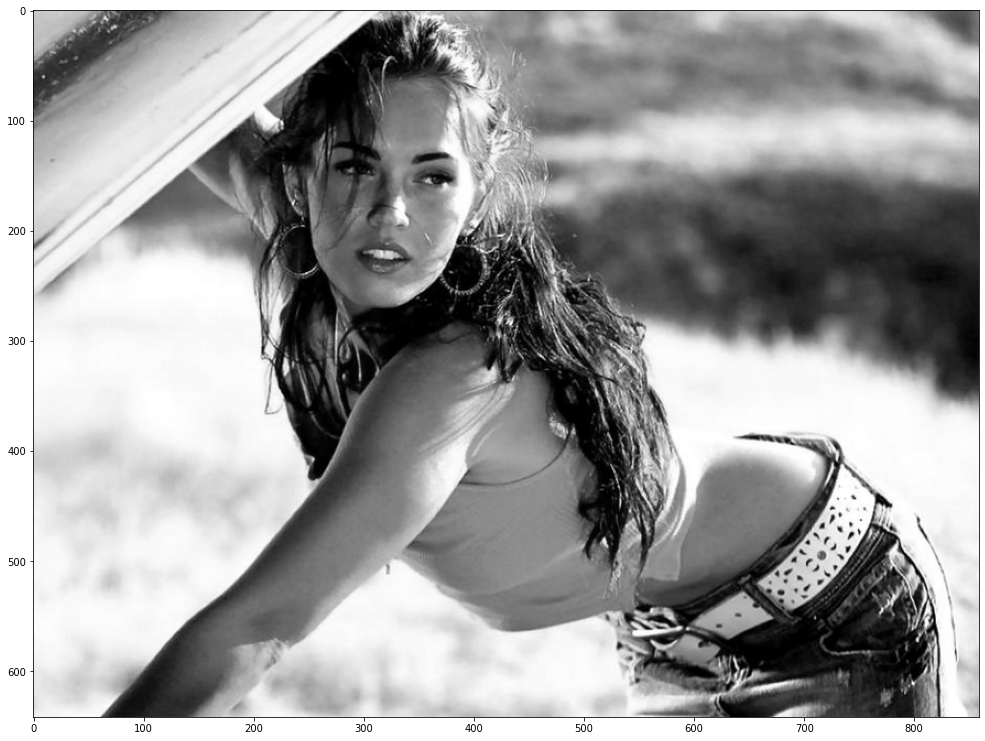

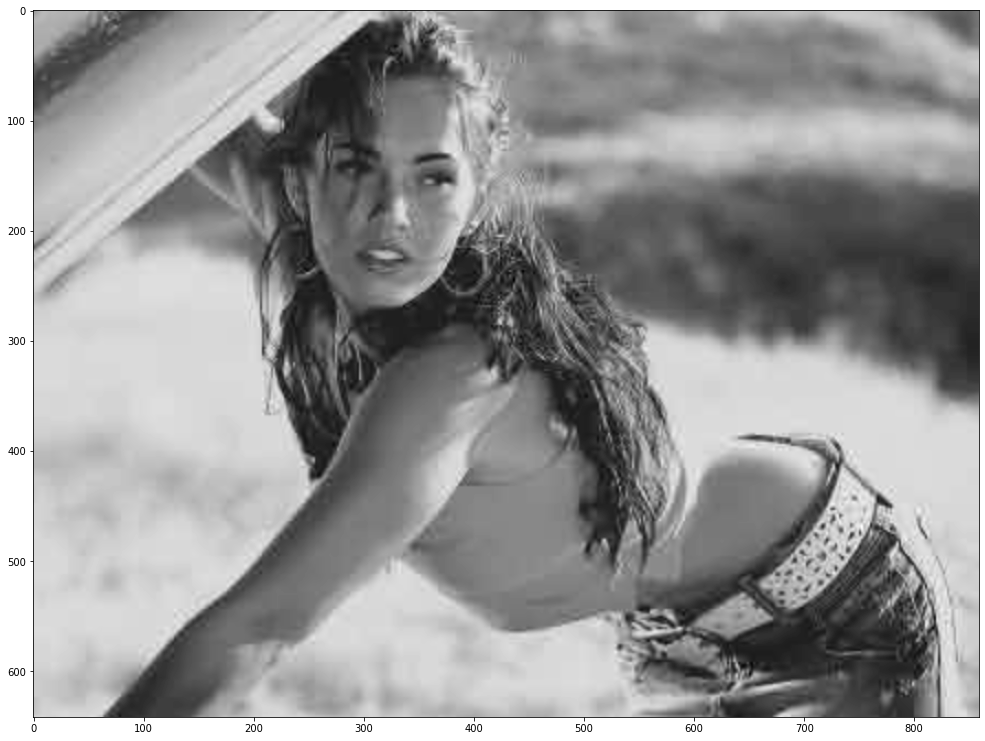

In [114]:
plt.rcParams["figure.figsize"] = [23,13]
plt.imshow(img_arr_gray, cmap='gray')
plt.show()
plt.imshow(dcp_data, cmap='gray')
plt.show()